# Visualizing Geometric Objects with Different Coordinates

In physics, we learn how to solve Newton's second law $\vec{f} = m\vec{a}$ very early.
We often write the equation in component form, e.g.,
\begin{align}
  f_x = m a_x \\
  f_y = m a_y
\end{align}
and solve the set of multiple equations without too much thinking.
The concept of physics laws need to be independent of coordinate systems often come much later.

Some authors describe the choice of coordiante systems in general relativity as "gauge freedom" for gravity theory.
However, such a concept is does not need to be that difficult.
If some equations are capable to describe some natural phenomena, as we change our coordinate systems, we better have a way to tranform our equations so they describe the same phenomena.
Similar, if there exist some some representations to describe an object, as we change our coordinate systems, we better have a way to tranform our presentations so they describe the same object.

In this notebook, we develop these transformations in order to visualize physical (or geometrical) objects in different coordinate systems.

## Setup

Before we start, we first install and import some standard python packages.

In [1]:
! pip install jaxlib==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_releases.html
! pip install fadge matplotlib

Looking in links: https://storage.googleapis.com/jax-releases/jax_releases.html


In [2]:
%load_ext autoreload
%autoreload 2

from jax.config import config
config.update("jax_enable_x64", True)

from jax import numpy as np, jacfwd, vmap
from fadge.geode import Geode
from matplotlib import pyplot as plt

## 2D Euclidean Space

In [3]:
def g_car(xy):
    x, y = xy
    return np.array([
        [1, 0],
        [0, 1],
    ])

def g_pol(rphi):
    r, phi = rphi
    return np.array([
        [1, 0],
        [0, r*r],
    ])

def car2pol(xy):
    x, y = xy
    return np.array([
        np.sqrt(x*x + y*y),
        np.arctan2(y, x),
    ])

def pol2car(rphi):
    r, phi = rphi
    return np.array([
        r * np.cos(phi),
        r * np.sin(phi),
    ])

In [4]:
def vmap2(f):
    return vmap(vmap(f))

def mgrid(I, J):
    return np.einsum('ijk->jki', np.mgrid[:I,:J])

### Drawing Circles

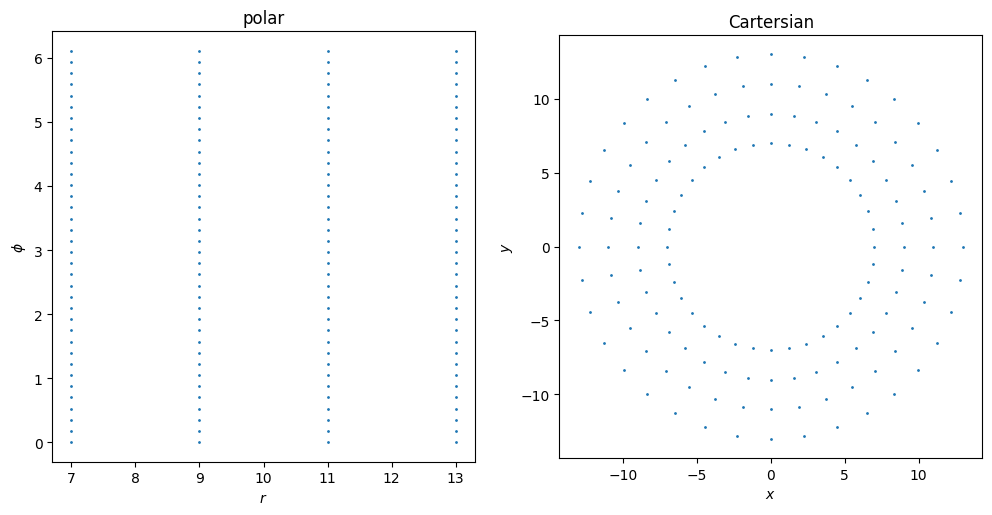

In [5]:
def sample_pol(ij):
    i, j = ij
    dr,   r0   = 2.0, 7.0
    dphi, phi0 = 2.0 * np.pi / 36, 0.0    
    return np.array([r0 + dr * i , phi0 + dphi * j])

R = vmap2(sample_pol)(mgrid(4,36))
X = vmap2(pol2car)(R)

fig, axes = plt.subplots(1,2, figsize=(12,6))

axes[0].scatter(R[...,0], R[...,1], s=1)
axes[0].set_title('polar')
axes[0].set_xlabel('$r$')
axes[0].set_ylabel('$\phi$')
axes[0].set_aspect('equal')

axes[1].scatter(X[...,0], X[...,1], s=1)
axes[1].set_title('Cartersian')
axes[1].set_xlabel('$x$')
axes[1].set_ylabel('$y$')
axes[1].set_aspect('equal')

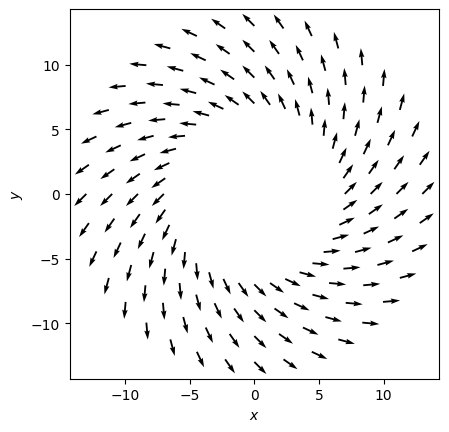

In [6]:
def field_pol(rphi):
    r, phi = rphi
    return np.array([1.0, 1 / r])

U = vmap2(field_pol)(R)
J = vmap2(jacfwd(pol2car))(R)
V = np.einsum('...ia,...a->...i', J, U)

fig, ax = plt.subplots(1,1)
ax.quiver(
    X[...,0], X[...,1], 
    V[...,0], V[...,1],
)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

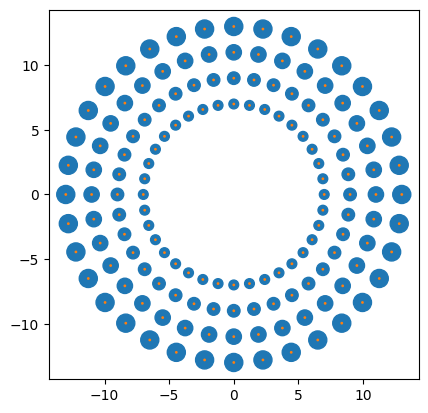

In [7]:
def area(g):
    return np.linalg.det(g)

G_car = vmap2(g_car)(X)
G_pol = vmap2(g_pol)(R)

plt.scatter(X[...,0], X[...,1], s=vmap2(area)(G_pol))
plt.scatter(X[...,0], X[...,1], s=vmap2(area)(G_car))
plt.gca().set_aspect('equal')

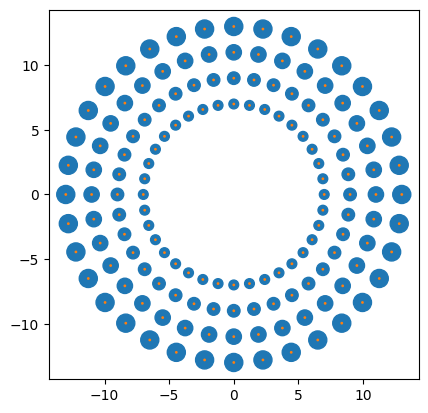

In [8]:
iJ = vmap2(jacfwd(car2pol))(X)

G_pol2 = np.einsum('...ai,...bj,...ab->...ij',  J,  J, G_car)
G_car2 = np.einsum('...ai,...bj,...ab->...ij', iJ, iJ, G_pol)

plt.scatter(X[...,0], X[...,1], s=vmap2(area)(G_pol2))
plt.scatter(X[...,0], X[...,1], s=vmap2(area)(G_car2))
plt.gca().set_aspect('equal')